In [86]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets
from sklearn.datasets import make_classification
from sklearn import model_selection

import numpy as np

**1. Задание:**
 - **Сформировать с помощью `sklearn.make_classification` датасет из 1000 объектов с двумя признаками.**
 - **Обучить случайный лес из 1, 3, 10, 50, 100 и 200 деревьев (за основу взять реализацию построения этого алгоритма из урока).**
 - **Визуализировать их разделяющие линии на графиках (по подобию визуализации деревьев из предыдущего урока, необходимо только заменить вызов функции `predict` на `tree_vote`).**
 - **Сделать выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нем.**
 


In [87]:
# сгенерируем данные из 1000 объектов с 2-мя признаками
X, y = make_classification(n_samples=1000,
                           n_features=2, n_informative=2, 
                           n_classes=2, n_redundant=0, 
                           n_clusters_per_class=2, flip_y=0.1, random_state=1)

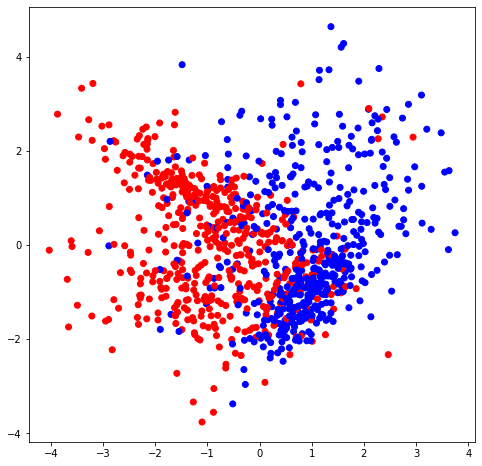

In [88]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], X)), list(map(lambda x: x[1], X)), 
              c=y, cmap=colors);

In [89]:
# Реализуем генерацию  N  бутстрап-выборок и подмножества признаков для нахождения разбиения в узле.
# Работает со строками - объектами
# data - все признаки
# labels - ответы
# N - число деревьев, которые нужно сформировать

random.seed(42)

def get_bootstrap(data, labels, N):
    n_samples = data.shape[0] # количество объектов
    bootstrap = []
    
    for i in range(N):
        b_data = np.zeros(data.shape)
        b_labels = np.zeros(labels.shape)
        
        for j in range(n_samples):
            sample_index = random.randint(0, n_samples-1)
            b_data[j] = data[sample_index]
            b_labels[j] = labels[sample_index]
        bootstrap.append((b_data, b_labels))
        
    # отловить неиспользуемые индексы данных для ошибки OOB

    return bootstrap

In [90]:
# Работает со столбцами - признаками
# будем сохранять не сами признаки, а их индексы
# len_sample - количество признаков всего

def get_subsample(len_sample):

    sample_indexes = [i for i in range(len_sample)]
    
    len_subsample = int(np.sqrt(len_sample)) # см. рекомендации, размер подвыборки
    subsample = []
    
    random.shuffle(sample_indexes)
    for _ in range(len_subsample):
        subsample.append(sample_indexes.pop())
        
    return subsample

In [91]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [92]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction        

In [93]:
# Расчет критерия Джини
# Критерий информативности

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [94]:
# Расчет качества, прирост информации, критерий

def quality(left_labels, right_labels, current_gini):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [95]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [96]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels, min_leaf):
    
    #  обозначим минимальное количество объектов в узле
    # min_leaf = 1

    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    # выбор индекса из подвыборки длиной sqrt(n_features)
    subsample = get_subsample(n_features)
    
    for index in subsample:
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее min_leaf объекта
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [97]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels, min_leaf):

    # Находим в узле наилучшее разбиение
    quality, t, index = find_best_split(data, labels, min_leaf)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels, min_leaf)
    false_branch = build_tree(false_data, false_labels, min_leaf)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [98]:
# Функция формирования случайного леса

def random_forest(data, labels, n_trees, min_leaf):
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)
    
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels, min_leaf))
        
    return forest

In [99]:
# Функция классификации отдельного объекта

def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [100]:
# функция формирования предсказания по выборке на одном дереве

def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [101]:
# предсказание голосованием деревьев

def tree_vote(forest, data):

    # добавим предсказания всех деревьев в список
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))
    
    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))
    # predictions_per_object = list(np.array(predictions).T)
    
    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
        # voted_predictions.append(max(set(obj), key=list(obj).count))
        
    return voted_predictions

In [102]:
# Разобьем выборку на обучающую и тестовую

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(X, y, 
                                                                                    test_size = 0.3,
                                                                                    random_state = 1)

In [103]:
# Введем функцию подсчета точности как доли правильных ответов

def accuracy_metric(actual, predicted):
  
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [104]:
def get_meshgrid(data, step=0.05, border=1.2):
        x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
        y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
        return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

In [105]:
# Функция для сравнения результатов случайного леса

def rendom_forest_result(train_data, train_labels, test_data, test_labels, n_trees, min_leaf=1):
    forest = random_forest(train_data, train_labels, n_trees, min_leaf)  # Строим лес
    train_answers = tree_vote(forest, train_data)  # Получим ответы для обучающей выборки 
    test_answers = tree_vote(forest, test_data)  # И получим ответы для тестовой выборки
    train_accuracy = accuracy_metric(train_labels, train_answers)  # Точность на обучающей выборке
    test_accuracy = accuracy_metric(test_labels, test_answers)  # Точность на тестовой выборке

    print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')
    print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}\n\n')


    # Визуализируем дерево на графике    

    plt.figure(figsize = (16, 10))

    # график обучающей выборки
    plt.subplot(2,2,1)
    xx, yy = get_meshgrid(train_data)
    mesh_predictions = np.array(tree_vote(forest, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
    plt.title(f'Train accuracy ={train_accuracy:.3f}')

    # график тестовой выборки
    plt.subplot(2,2,2)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
    plt.title(f'Test accuracy ={test_accuracy:.3f}')

Точность случайного леса из 1 деревьев на обучающей выборке: 90.429
Точность случайного леса из 1 деревьев на тестовой выборке: 68.667




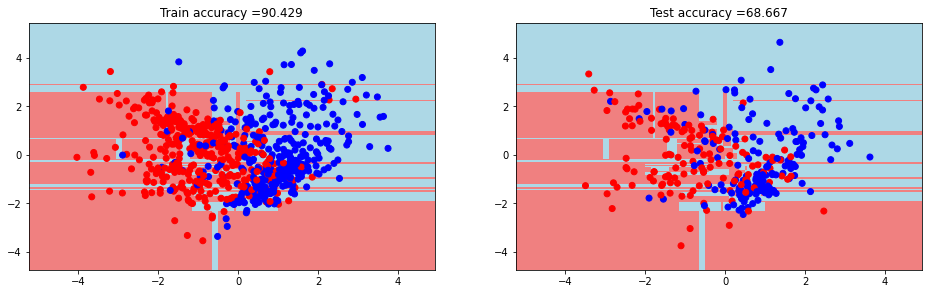

In [106]:
# 1 дерево
rendom_forest_result(train_data, train_labels, test_data, test_labels, 1)

Точность случайного леса из 3 деревьев на обучающей выборке: 95.714
Точность случайного леса из 3 деревьев на тестовой выборке: 77.000




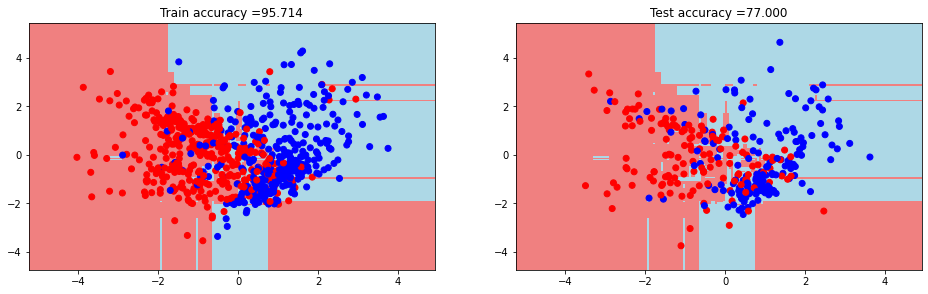

In [107]:
# 3 дерева
rendom_forest_result(train_data, train_labels, test_data, test_labels, 3)

Точность случайного леса из 10 деревьев на обучающей выборке: 99.000
Точность случайного леса из 10 деревьев на тестовой выборке: 78.333




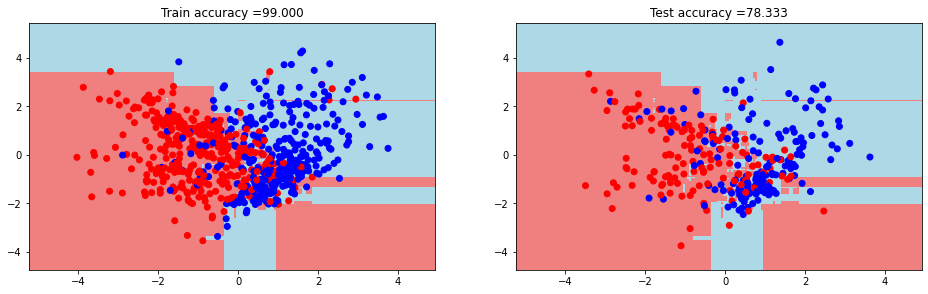

In [108]:
# 10 деревьев
rendom_forest_result(train_data, train_labels, test_data, test_labels, 10)

Точность случайного леса из 50 деревьев на обучающей выборке: 100.000
Точность случайного леса из 50 деревьев на тестовой выборке: 79.333




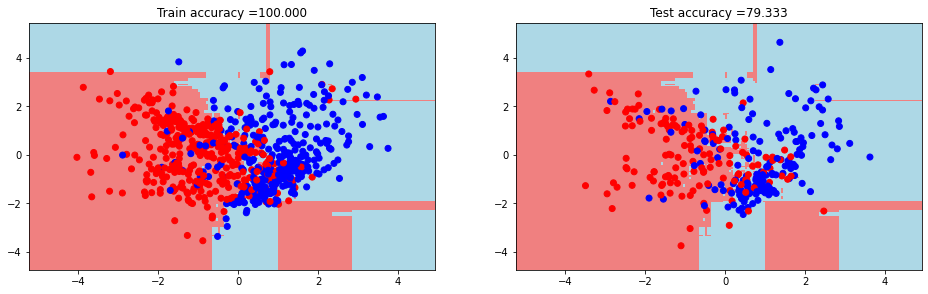

In [109]:
# 50 деревьев
rendom_forest_result(train_data, train_labels, test_data, test_labels, 50)

Точность случайного леса из 100 деревьев на обучающей выборке: 100.000
Точность случайного леса из 100 деревьев на тестовой выборке: 79.667




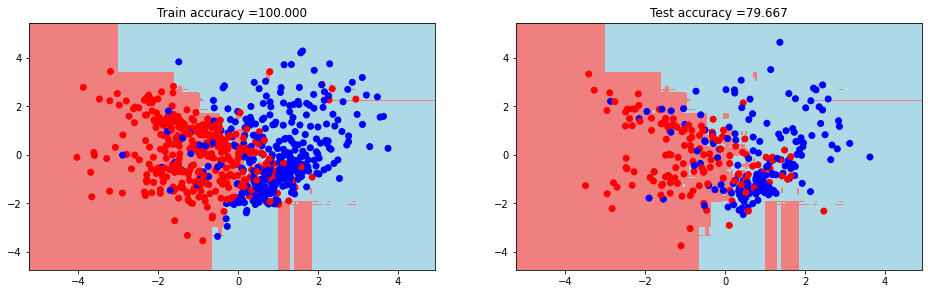

In [110]:
# 100 деревьев
rendom_forest_result(train_data, train_labels, test_data, test_labels, 100)

Точность случайного леса из 200 деревьев на обучающей выборке: 100.000
Точность случайного леса из 200 деревьев на тестовой выборке: 79.333




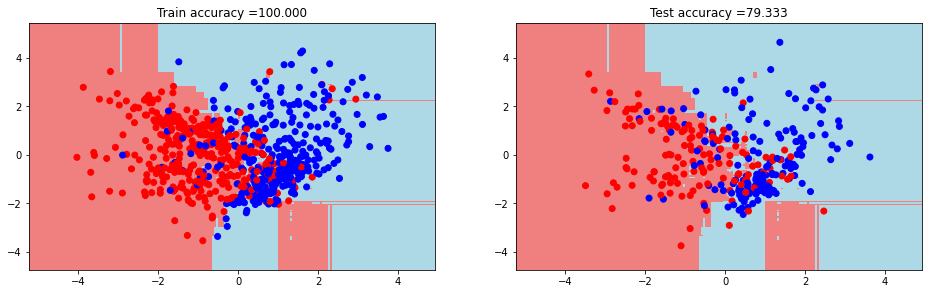

In [111]:
# 200 деревьев
rendom_forest_result(train_data, train_labels, test_data, test_labels, 200)

**Вывод:** Алгоритм случайного леса при слишком большом количестве деревьев может переобучиться. Показателями этого являются точность на обучающей выборке 100%. Также в данном примере при количестве 200 деревьев точность расчета на тестовой выборке даже начинает снижаться.

Следует применить критерии останова для достижения большей точности без возможности переобучения.

Например, при увеличении количества объектов в листе до 5 точность на тестовой выборке при 100 деревьях выше, чем при количестве объектов - 1 (**80.333** против **79.667**), при этом на обущающей выборке нет переоучения, так как точноть равна **90.143**.

Точность случайного леса из 100 деревьев на обучающей выборке: 90.143
Точность случайного леса из 100 деревьев на тестовой выборке: 80.333




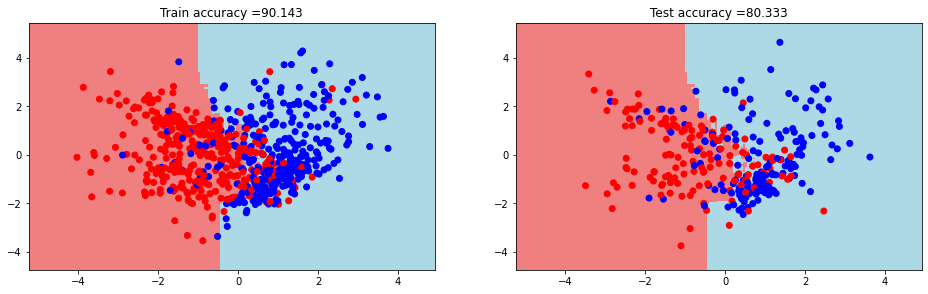

In [112]:
# 100 деревьев
rendom_forest_result(train_data, train_labels, test_data, test_labels, 100, 5)

**2. (\*) Заменить в реализованном алгоритме проверку с помощью отложенной выборки на Out-of-Bag.**



In [113]:
X, y = make_classification(n_samples=1000,
                           n_features=2, n_informative=2, 
                           n_classes=2, n_redundant=0, 
                           n_clusters_per_class=2, flip_y=0.1, random_state=1)

In [114]:
# Реализуем проверку с помощью отложенной выборки на Out-of-Bag

def get_bootstrap_OOB(data, labels, N):

    random.seed(42)
    n_samples = data.shape[0] # количество объектов 1000
    bootstrap = []
    sample_index_used = set()
    sample_index_not_used = []
    train_data_oob = []  # Данные, которые попали в выборку
    train_labels_oob = []  # Ответы, которые попали в выборку
    valid_data_oob = []  # Данные, которые не попали в выборку
    valid_labels_oob = []  # Ответы, которые не попали в выборку
    
    for i in range(N):
        b_data = np.zeros(data.shape)
        b_labels = np.zeros(labels.shape)
        
        for j in range(n_samples):
            sample_index = random.randint(0, n_samples-1)
            b_data[j] = data[sample_index]
            b_labels[j] = labels[sample_index]
            sample_index_used.add(sample_index)            
        bootstrap.append((b_data, b_labels))

        for k in range(n_samples):
            if k not in sample_index_used:
                sample_index_not_used.append(k)

        for i_used in sample_index_used:
            train_data_oob.append(list(data[i_used]))
            train_labels_oob.append(labels[i_used])
        
        for i_not_used in sample_index_not_used:
            valid_data_oob.append(list(data[i_not_used]))
            valid_labels_oob.append(labels[i_not_used])
    
    return bootstrap, train_data_oob, train_labels_oob, valid_data_oob, valid_labels_oob